# **Tugas Database Multimedia**
* Aisyah Tiara Pratiwi
* 121450074
* RC

* Title: Three Ways of Storing and Accessing Lots of Images in Python
* URL: https://realpython.com/storing-images-in-python/


# **Pendahuluan**
Saat ini, jumlah gambar yang dibutuhkan untuk tugas tertentu, seperti pelatihan model deep learning, semakin besar. Algoritma seperti Convolutional Neural Network (CNN) dapat menangani dataset gambar yang sangat besar dan bahkan belajar darinya. Namun, memuat semua gambar tersebut ke dalam memori untuk pelatihan dapat memakan waktu yang lama.

Artikel ini membahas tiga cara untuk menyimpan dan mengakses banyak gambar di Python:

- Menyimpan gambar pada disk sebagai file .png
- Menyimpan gambar dalam Lightning Memory-Mapped Database (LMDB)
- Menyimpan gambar dalam Hierarchical Data Format (HDF5)




# **Setup**

## A Dataset to Play With

> Memuat dataset CIFAR-10 yang telah diunduh ke dalam memori

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pickle
from pathlib import Path

# Path to the unzipped CIFAR data
data_dir = Path("/content/drive/MyDrive/cifar-10-batches-py")

# Unpickle function provided by the CIFAR hosts
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

images, labels = [], []
for batch in data_dir.glob("data_batch_*"):
    batch_data = unpickle(batch)
    for i, flat_im in enumerate(batch_data[b"data"]):
        im_channels = []
        # Each image is flattened, with channels in order of R, G, B
        for j in range(3):
            im_channels.append(
                flat_im[j * 1024 : (j + 1) * 1024].reshape((32, 32))
            )
        # Reconstruct the original image
        images.append(np.dstack((im_channels)))
        # Save the label
        labels.append(batch_data[b"labels"][i])

print("Loaded CIFAR-10 training set:")
print(f" - np.shape(images)     {np.shape(images)}")
print(f" - np.shape(labels)     {np.shape(labels)}")

Loaded CIFAR-10 training set:
 - np.shape(images)     (50000, 32, 32, 3)
 - np.shape(labels)     (50000,)


## Setup for Storing Images on Disk

>Paket Python: Pillow (untuk manipulasi gambar), lmdb (untuk LMDB), dan h5py (untuk HDF5)

In [3]:
! pip install Pillow
! pip install h5py
! pip install lmdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 6.2 MB/s eta 0:00:00


# **Storing a Single Image**

> Membandingkan cara menyimpan sebuah gambar ke dalam format .png menggunakan tiga metode berbeda: langsung ke disk, menggunakan LMDB, dan menggunakan HDF5. Pertama, kita siapkan folder untuk setiap metode. Kemudian, kita akan menyimpan gambar pertama dari dataset CIFAR dan labelnya menggunakan tiga metode yang berbeda. Setelah itu, kita akan mengukur waktu yang diperlukan untuk setiap metode menggunakan modul timeit.

In [4]:
from pathlib import Path

disk_dir = Path("data/disk/")
lmdb_dir = Path("data/lmdb/")
hdf5_dir = Path("data/hdf5/")

In [5]:
disk_dir.mkdir(parents=True, exist_ok=True)
lmdb_dir.mkdir(parents=True, exist_ok=True)
hdf5_dir.mkdir(parents=True, exist_ok=True)

## Storing to Disk

> Pertama, untuk menyimpan gambar ke disk, kita menggunakan library Pillow untuk menyimpan gambar dalam format .png dan menyimpan labelnya dalam file .csv terpisah.

In [7]:
from PIL import Image
import csv

def store_single_disk(image, image_id, label):
    """ Stores a single image as a .png file on disk.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    Image.fromarray(image).save(disk_dir / f"{image_id}.png")

    with open(disk_dir / f"{image_id}.csv", "wt") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        writer.writerow([label])

## Storing to LMDB

> Kedua, untuk menyimpan gambar ke LMDB, kita perlu menggunakan serialisasi untuk mengonversi gambar dan labelnya menjadi string sebelum menyimpannya ke dalam database LMDB.

In [8]:
class CIFAR_Image:
    def __init__(self, image, label):
        # Dimensions of image for reconstruction - not really necessary
        # for this dataset, but some datasets may include images of
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]

        self.image = image.tobytes()
        self.label = label

    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)

In [9]:
import lmdb
import pickle

def store_single_lmdb(image, image_id, label):
    """ Stores a single image to a LMDB.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    map_size = image.nbytes * 10

    # Create a new LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), map_size=map_size)

    # Start a new write transaction
    with env.begin(write=True) as txn:
        # All key-value pairs need to be strings
        value = CIFAR_Image(image, label)
        key = f"{image_id:08}"
        txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

## Storing With HDF5

>Ketiga, untuk menyimpan gambar ke HDF5, kita menggunakan library h5py untuk membuat file HDF5 dan menyimpan gambar serta labelnya sebagai dua dataset terpisah di dalam file tersebut.

In [10]:
import h5py

def store_single_hdf5(image, image_id, label):
    """ Stores a single image to an HDF5 file.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "image", np.shape(image), h5py.h5t.STD_U8BE, data=image
    )
    meta_set = file.create_dataset(
        "meta", np.shape(label), h5py.h5t.STD_U8BE, data=label
    )
    file.close()

## Experiments for Storing a Single Image

>Setelah semua fungsi penyimpanan telah dibuat, kita akan menjalankan eksperimen untuk menyimpan gambar pertama dari CIFAR-10 dan melihat berapa lama waktu yang diperlukan oleh masing-masing metode. Dengan demikian, kita dapat membandingkan waktu yang diperlukan dan jumlah memori yang digunakan oleh setiap metode.

In [11]:
_store_single_funcs = dict(
    disk=store_single_disk, lmdb=store_single_lmdb, hdf5=store_single_hdf5
)

In [12]:
from timeit import timeit

store_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_store_single_funcs[method](image, 0, label)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    store_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.014777650000041831
Method: lmdb, Time usage: 0.007616498999993837
Method: hdf5, Time usage: 0.002053470000021207


> Hasil eksperimen menunjukkan bahwa semua metode menyimpan gambar dengan cepat. Namun, dari segi penggunaan memori, LMDB menggunakan lebih banyak memori dibandingkan dengan metode lainnya. Meskipun demikian, kita harus mempertimbangkan kelebihan dan kekurangan masing-masing metode sesuai dengan kebutuhan aplikasi kita.

# **Storing Many Images**

>Untuk menyimpan banyak gambar, kita perlu menyesuaikan kode agar dapat menangani banyak gambar sekaligus. Untuk metode penyimpanan ke file .png, cukup memanggil fungsi store_single_method() beberapa kali. Namun, hal ini tidak berlaku untuk LMDB atau HDF5, karena kita tidak ingin memiliki file database yang berbeda untuk setiap gambar. Sebaliknya, kita ingin menyimpan semua gambar ke dalam satu atau beberapa file.

## Adjusting the Code for Many Images

>Kita perlu sedikit mengubah kode dan membuat tiga fungsi baru yang menerima banyak gambar: store_many_disk(), store_many_lmdb(), dan store_many_hdf5().

Untuk penyimpanan ke disk, setiap gambar disimpan secara terpisah sebagai file .png dengan nama file yang unik, sementara semua label disimpan dalam satu file .csv. Metode ini memungkinkan penyimpanan yang mudah diakses dan dapat dibaca oleh manusia, namun memerlukan manajemen file yang lebih kompleks saat jumlah gambar meningkat.

Sementara itu, untuk penyimpanan ke LMDB, semua gambar dan label disimpan dalam satu database LMDB. Setiap gambar direpresentasikan sebagai objek CIFAR_Image yang disimpan menggunakan kunci unik. Meskipun lebih rumit dalam implementasinya, LMDB menawarkan keuntungan dalam hal kinerja dan pengelolaan memori, terutama ketika jumlah gambar menjadi besar.

Di sisi lain, penyimpanan ke HDF5 melibatkan semua gambar dan label disimpan dalam satu file HDF5. Dibuat satu dataset untuk gambar dan satu dataset untuk label. Seperti LMDB, HDF5 juga menawarkan kinerja yang baik dan pengelolaan memori efisien, dengan keuntungan tambahan dalam fleksibilitas penyimpanan data yang lebih besar.





In [14]:
def store_many_disk(images, labels):
    """ Stores an array of images to disk
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Save all the images one by one
    for i, image in enumerate(images):
        Image.fromarray(image).save(disk_dir / f"{i}.png")

    # Save all the labels to the csv file
    with open(disk_dir / f"{num_images}.csv", "w") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for label in labels:
            # This typically would be more than just one value per row
            writer.writerow([label])

def store_many_lmdb(images, labels):
    """ Stores an array of images to LMDB.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    map_size = num_images * images[0].nbytes * 10

    # Create a new LMDB DB for all the images
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), map_size=map_size)

    # Same as before — but let's write all the images in a single transaction
    with env.begin(write=True) as txn:
        for i in range(num_images):
            # All key-value pairs need to be Strings
            value = CIFAR_Image(images[i], labels[i])
            key = f"{i:08}"
            txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

def store_many_hdf5(images, labels):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    meta_set = file.create_dataset(
        "meta", np.shape(labels), h5py.h5t.STD_U8BE, data=labels
    )
    file.close()

## Preparing the Dataset

>Setelah membuat fungsi-fungsi penyimpanan untuk banyak gambar, kita perlu menyiapkan dataset untuk eksperimen dengan meningkatkan ukurannya. Dataset diperbesar menjadi 100.000 gambar dengan menggandakan array gambar dan label. Hal ini dilakukan agar dapat menguji kinerja dari ketiga metode penyimpanan untuk jumlah gambar yang besar.

In [15]:
cutoffs = [10, 100, 1000, 10000, 100000]

# Let's double our images so that we have 100,000
images = np.concatenate((images, images), axis=0)
labels = np.concatenate((labels, labels), axis=0)

# Make sure you actually have 100,000 images and labels
print(np.shape(images))
print(np.shape(labels))

(100000, 32, 32, 3)
(100000,)


## Experiment for Storing Many Images

>Eksperimen kemudian dilakukan untuk mengukur waktu yang diperlukan untuk menyimpan banyak gambar menggunakan ketiga metode tersebut. Waktu yang diukur digunakan untuk membuat grafik yang membandingkan waktu penyimpanan untuk berbagai metode terhadap jumlah gambar yang disimpan. Hasil eksperimen menunjukkan bahwa LMDB dan HDF5 memiliki kinerja yang lebih baik dibandingkan penyimpanan ke disk, terutama saat jumlah gambar menjadi besar.

In [16]:
_store_many_funcs = dict(
    disk=store_many_disk, lmdb=store_many_lmdb, hdf5=store_many_hdf5
)

from timeit import timeit

store_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_store_many_funcs[method](images_, labels_)",
            setup="images_=images[:cutoff]; labels_=labels[:cutoff]",
            number=1,
            globals=globals(),
        )
        store_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.01086361899979238
Method: lmdb, Time usage: 0.009364640000057989
Method: hdf5, Time usage: 0.003909671000201342
Method: disk, Time usage: 0.03260133899993889
Method: lmdb, Time usage: 0.015331569999943895
Method: hdf5, Time usage: 0.0013734100000419858
Method: disk, Time usage: 0.3019326099999944
Method: lmdb, Time usage: 0.04430112799991548
Method: hdf5, Time usage: 0.005557269999826531
Method: disk, Time usage: 3.515245253999865
Method: lmdb, Time usage: 0.41436891600005765
Method: hdf5, Time usage: 0.04407526799991501
Method: disk, Time usage: 32.07742516199983
Method: lmdb, Time usage: 8.486099637000052
Method: hdf5, Time usage: 0.47356489499998133


<ipython-input-17-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


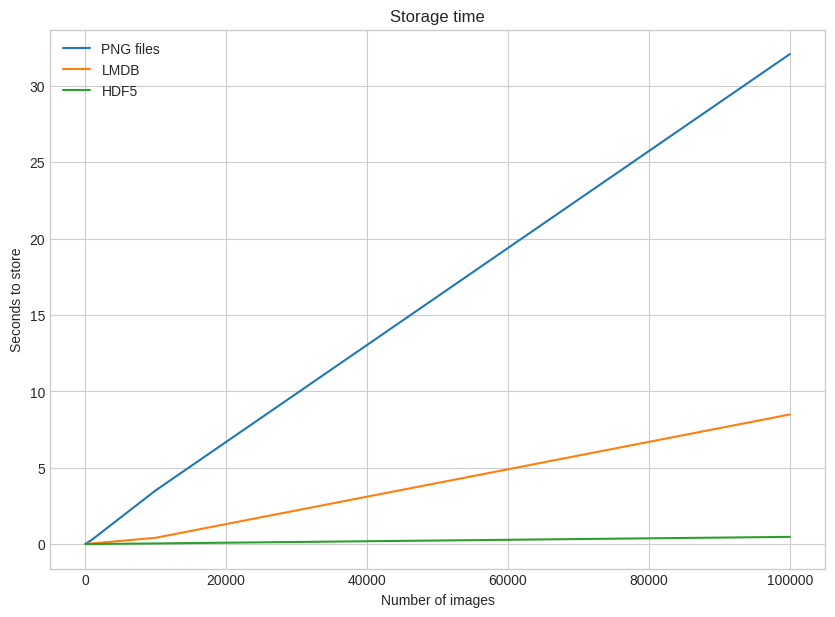

<ipython-input-17-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


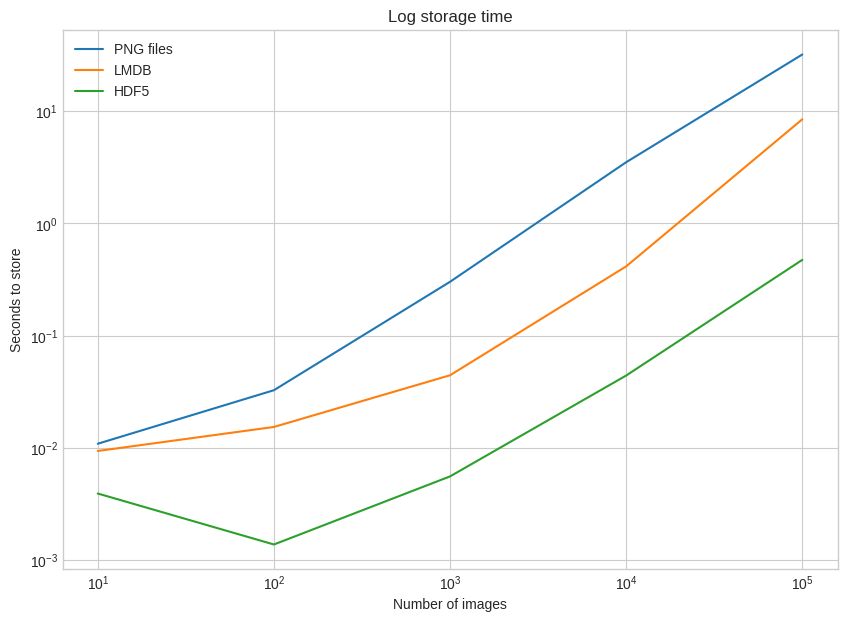

In [17]:
import matplotlib.pyplot as plt

def plot_with_legend(
    x_range, y_data, legend_labels, x_label, y_label, title, log=False
):
    """ Displays a single plot with multiple datasets and matching legends.
        Parameters:
        --------------
        x_range         list of lists containing x data
        y_data          list of lists containing y values
        legend_labels   list of string legend labels
        x_label         x axis label
        y_label         y axis label
    """
    plt.style.use("seaborn-whitegrid")
    plt.figure(figsize=(10, 7))

    if len(y_data) != len(legend_labels):
        raise TypeError(
            "Error: number of data sets does not match number of labels."
        )

    all_plots = []
    for data, label in zip(y_data, legend_labels):
        if log:
            temp, = plt.loglog(x_range, data, label=label)
        else:
            temp, = plt.plot(x_range, data, label=label)
        all_plots.append(temp)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(handles=all_plots)
    plt.show()

# Getting the store timings data to display
disk_x = store_many_timings["disk"]
lmdb_x = store_many_timings["lmdb"]
hdf5_x = store_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Storage time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Log storage time",
    log=True,
)

# **Reading a Single Image**

## Reading From Disk

>Kita telah membahas proses membaca sebuah gambar tunggal ke dalam sebuah array untuk masing-masing dari tiga metode penyimpanan yang berbeda. Pertama, mari kita lihat bagaimana cara membaca sebuah gambar tunggal bersama metadatanya dari file .png dan .csv. Fungsi read_single_disk(image_id) membuka file gambar .png dan file metadatanya .csv. Gambar dibaca menggunakan modul PIL dan dikonversi ke dalam sebuah array numpy, sedangkan label atau metadatanya dibaca dari file .csv menggunakan modul csv.

In [18]:
def read_single_disk(image_id):
    """ Stores a single image to disk.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    image = np.array(Image.open(disk_dir / f"{image_id}.png"))

    with open(disk_dir / f"{image_id}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        label = int(next(reader)[0])

    return image, label

## Reading From LMDB

>Kemudian, untuk membaca gambar yang sama bersama metadatanya dari sebuah LMDB, kita menggunakan fungsi read_single_lmdb(image_id). Di sini, kita membuka environment LMDB dan memulai transaksi baca. Kunci yang sesuai dengan ID gambar dikodekan secara mirip dengan saat kita menyimpannya. Setelah mendapatkan data dari LMDB, objek CIFAR_Image di-rekonstruksi dari string yang disalin kembali menggunakan pickle, dan gambar serta labelnya diekstrak.

In [19]:
def read_single_lmdb(image_id):
    """ Stores a single image to LMDB.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Encode the key the same way as we stored it
        data = txn.get(f"{image_id:08}".encode("ascii"))
        # Remember it's a CIFAR_Image object that is loaded
        cifar_image = pickle.loads(data)
        # Retrieve the relevant bits
        image = cifar_image.get_image()
        label = cifar_image.label
    env.close()

    return image, label

## Reading From HDF5

> Terakhir, untuk membaca dari HDF5, kita menggunakan fungsi read_single_hdf5(image_id). Prosesnya mirip dengan penulisan sebelumnya. Kita membuka file HDF5 dan mengakses dataset yang berisi gambar dan metadatanya. Gambar dan label diekstrak dari dataset yang sesuai.

In [20]:
def read_single_hdf5(image_id):
    """ Stores a single image to HDF5.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "r+")

    image = np.array(file["/image"]).astype("uint8")
    label = int(np.array(file["/meta"]).astype("uint8"))

    return image, label

In [21]:
_read_single_funcs = dict(
    disk=read_single_disk, ldibumdb=read_single_lmdb, hdf5=read_single_hdf5
)

## Experiment for Reading a Single Image

> Setelah menyiapkan fungsi-fungsi baca, kita dapat menjalankan eksperimen untuk membaca sebuah gambar tunggal menggunakan masing-masing metode. Dalam eksperimen ini, kita mengukur waktu yang diperlukan untuk membaca sebuah gambar dan metadatanya dari masing-masing metode. Hasil eksperimen menunjukkan bahwa membaca file .png dan .csv langsung dari disk sedikit lebih cepat dibandingkan dengan menggunakan LMDB atau HDF5. Namun, semua metode menampilkan kinerja yang sangat cepat, dengan perbedaan waktu yang hampir tidak signifikan. Eksperimen selanjutnya akan lebih menarik untuk dilakukan.

In [22]:
from timeit import timeit

read_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_read_single_funcs[method](0)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    read_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.001847790000056193
Method: lmdb, Time usage: 0.000312359999952605
Method: hdf5, Time usage: 0.001777129999936733


# **Reading Many Images**

## Adjusting the Code for Many Images

>Setelah melakukan penyesuaian kode untuk membaca banyak gambar sekaligus, kita dapat melihat bagaimana metode tersebut memengaruhi kinerja waktu baca dan penggunaan ruang disk.

>Fungsi read_many_disk(num_images) memungkinkan kita untuk membaca banyak gambar sekaligus dari disk. Dalam proses ini, kita melintasi semua ID gambar dan membaca setiap gambar secara berurutan. Kemudian, kita membaca label atau metadatanya dari file .csv yang sesuai.

>Untuk membaca banyak gambar dari LMDB, digunakan fungsi read_many_lmdb(num_images). Pada proses ini, kita membuka environment LMDB dan memulai transaksi baca. Kemudian, semua gambar dibaca dalam satu transaksi tunggal dengan satu kunci baca.

>Terakhir, dalam fungsi read_many_hdf5(num_images), kita membuka file HDF5 dan mengakses dataset yang berisi semua gambar dan metadatanya.

In [23]:
def read_many_disk(num_images):
    """ Reads image from disk.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Loop over all IDs and read each image in one by one
    for image_id in range(num_images):
        images.append(np.array(Image.open(disk_dir / f"{image_id}.png")))

    with open(disk_dir / f"{num_images}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for row in reader:
            labels.append(int(row[0]))
    return images, labels

def read_many_lmdb(num_images):
    """ Reads image from LMDB.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Read all images in one single transaction, with one lock
        # We could split this up into multiple transactions if needed
        for image_id in range(num_images):
            data = txn.get(f"{image_id:08}".encode("ascii"))
            # Remember that it's a CIFAR_Image object
            # that is stored as the value
            cifar_image = pickle.loads(data)
            # Retrieve the relevant bits
            images.append(cifar_image.get_image())
            labels.append(cifar_image.label)
    env.close()
    return images, labels

def read_many_hdf5(num_images):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "r+")

    images = np.array(file["/images"]).astype("uint8")
    labels = np.array(file["/meta"]).astype("uint8")

    return images, labels

_read_many_funcs = dict(
    disk=read_many_disk, lmdb=read_many_lmdb, hdf5=read_many_hdf5
)

## Experiment for Reading Many Images

>Dengan fungsi-fungsi baca yang disimpan dalam sebuah kamus seperti pada fungsi tulis, kita dapat menjalankan eksperimen untuk membaca banyak gambar sekaligus. Pada eksperimen ini, kita mengukur waktu yang diperlukan untuk membaca banyak gambar dari masing-masing metode berdasarkan jumlah gambar yang dibaca. Hasil eksperimen menunjukkan bahwa penggunaan metode LMDB dan HDF5 memberikan kinerja waktu yang lebih baik dibandingkan dengan metode penyimpanan gambar dalam format .png.

In [24]:
from timeit import timeit

read_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_read_many_funcs[method](num_images)",
            setup="num_images=cutoff",
            number=1,
            globals=globals(),
        )
        read_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, No. images: {cutoff}, Time usage: {t}")

Method: disk, No. images: 10, Time usage: 0.020566468999959397
Method: lmdb, No. images: 10, Time usage: 0.00865920000001097
Method: hdf5, No. images: 10, Time usage: 0.004481819999909931
Method: disk, No. images: 100, Time usage: 0.026596330000074886
Method: lmdb, No. images: 100, Time usage: 0.00800359999993816
Method: hdf5, No. images: 100, Time usage: 0.009389790000113862
Method: disk, No. images: 1000, Time usage: 0.2734864869999001
Method: lmdb, No. images: 1000, Time usage: 0.0383588099998633
Method: hdf5, No. images: 1000, Time usage: 0.04219577999992907
Method: disk, No. images: 10000, Time usage: 2.770470848000059
Method: lmdb, No. images: 10000, Time usage: 0.280121237000003
Method: hdf5, No. images: 10000, Time usage: 0.2622504179998941
Method: disk, No. images: 100000, Time usage: 24.464113046999955
Method: lmdb, No. images: 100000, Time usage: 1.7232099099999232
Method: hdf5, No. images: 100000, Time usage: 0.6101996540000982


>Perbedaan yang signifikan terlihat pada grafik waktu baca log, di mana HDF5 mulai sedikit tertinggal dibandingkan dengan LMDB, namun seiring dengan penambahan jumlah gambar, kinerjanya menjadi lebih baik daripada LMDB.

<ipython-input-17-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


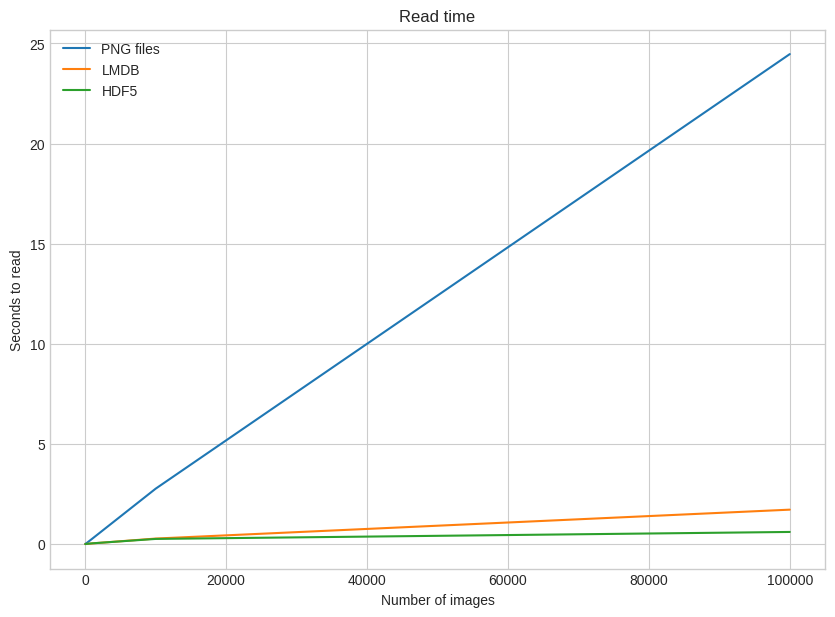

<ipython-input-17-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


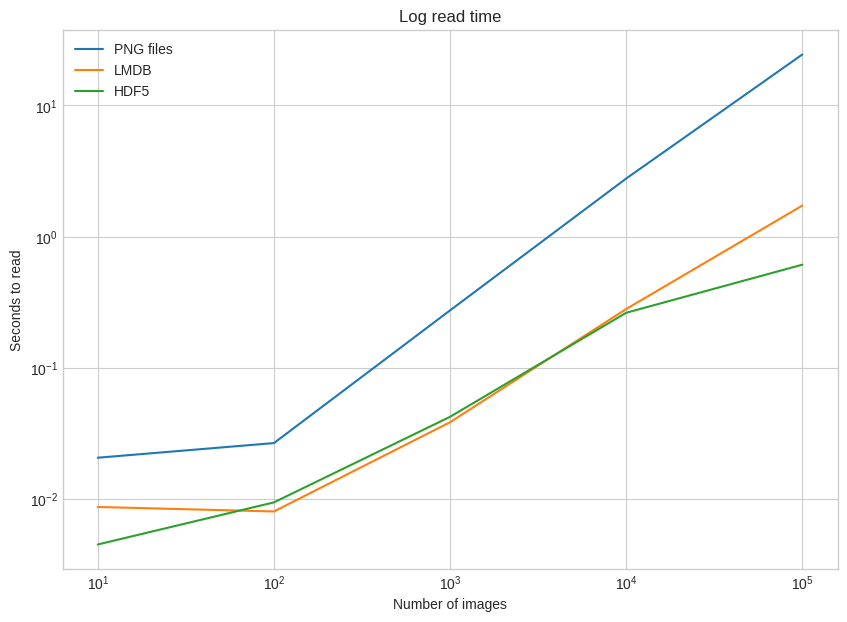

In [25]:
disk_x_r = read_many_timings["disk"]
lmdb_x_r = read_many_timings["lmdb"]
hdf5_x_r = read_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to read",
    "Read time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to read",
    "Log read time",
    log=True,
)

<ipython-input-17-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


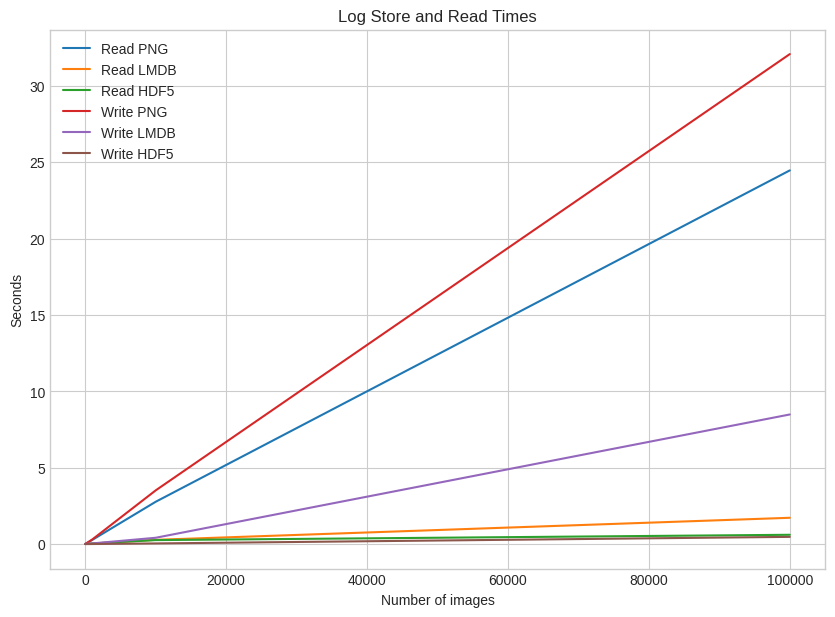

In [26]:
plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r, disk_x, lmdb_x, hdf5_x],
    [
        "Read PNG",
        "Read LMDB",
        "Read HDF5",
        "Write PNG",
        "Write LMDB",
        "Write HDF5",
    ],
    "Number of images",
    "Seconds",
    "Log Store and Read Times",
    log=False,
)

# **Considering Disk Usage**

>Selanjutnya, kita juga perlu mempertimbangkan penggunaan ruang disk. Grafik penggunaan ruang disk menunjukkan bahwa baik LMDB maupun HDF5 membutuhkan lebih banyak ruang disk dibandingkan dengan penyimpanan gambar dalam format .png. Ini disebabkan oleh berbagai faktor seperti caching dan ukuran halaman OS yang dimanfaatkan oleh LMDB.Secara keseluruhan, meskipun waktu baca lebih penting daripada waktu tulis, terdapat argumen kuat untuk menggunakan metode penyimpanan gambar dalam format LMDB atau HDF5. Selanjutnya, kita akan memasuki diskusi kualitatif mengenai perbedaan antara metode-metode tersebut.

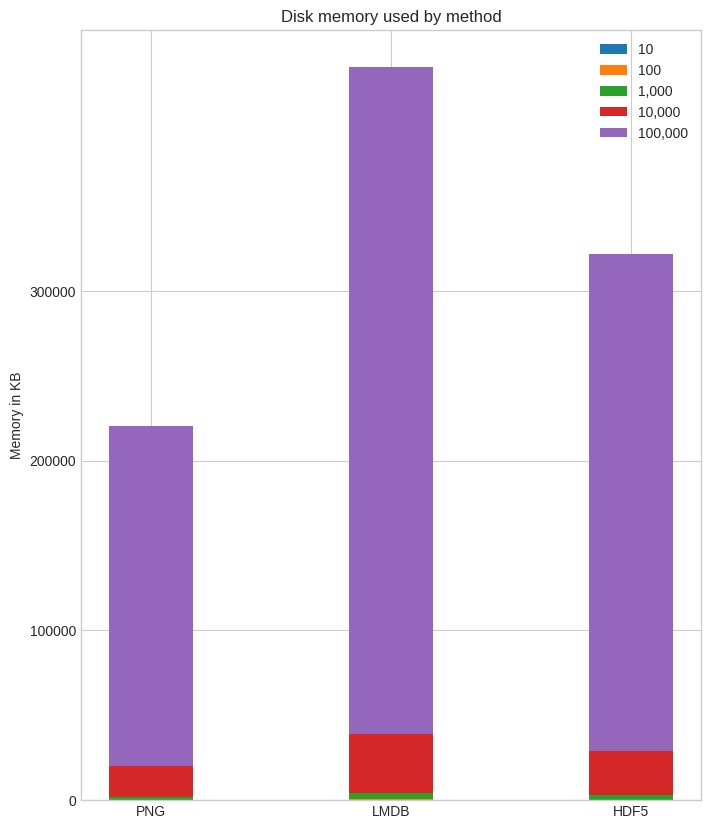

In [27]:
# Memory used in KB
disk_mem = [24, 204, 2004, 20032, 200296]
lmdb_mem = [60, 420, 4000, 39000, 393000]
hdf5_mem = [36, 304, 2900, 29000, 293000]

X = [disk_mem, lmdb_mem, hdf5_mem]

ind = np.arange(3)
width = 0.35

plt.subplots(figsize=(8, 10))
plots = [plt.bar(ind, [row[0] for row in X], width)]
for i in range(1, len(cutoffs)):
    plots.append(
        plt.bar(
            ind, [row[i] for row in X], width, bottom=[row[i - 1] for row in X]
        )
    )

plt.ylabel("Memory in KB")
plt.title("Disk memory used by method")
plt.xticks(ind, ("PNG", "LMDB", "HDF5"))
plt.yticks(np.arange(0, 400000, 100000))

plt.legend(
    [plot[0] for plot in plots], ("10", "100", "1,000", "10,000", "100,000")
)
plt.show()

# **Kesimpulan**
Dalam eksperimen ini, kami mengamati kinerja waktu dan penggunaan ruang disk dari tiga metode penyimpanan gambar: penyimpanan gambar sebagai file .png, penyimpanan dalam LMDB, dan penyimpanan dalam HDF5. Kami menemukan bahwa pembacaan dari LMDB dan HDF5 jauh lebih cepat daripada pembacaan dari file .png, terutama saat jumlah gambar yang besar. Namun, kami juga melihat bahwa penggunaan ruang disk dari LMDB dan HDF5 cenderung lebih besar daripada penyimpanan dalam format .png. Sementara itu, LMDB memiliki kinerja yang sangat efisien dalam menyimpan gambar kecil, tetapi untuk gambar yang lebih besar, HDF5 mungkin sedikit lebih efisien dalam penggunaan ruang disk.

Dengan demikian, kesimpulan utama dari eksperimen ini adalah bahwa dalam konteks pembacaan dan penyimpanan banyak gambar, metode penyimpanan dalam format LMDB dan HDF5 menawarkan kinerja waktu yang lebih baik daripada penyimpanan dalam format .png. Namun, penggunaan ruang disk harus dipertimbangkan dengan cermat terutama untuk gambar-gambar yang besar. Dalam prakteknya, pemilihan metode penyimpanan harus mempertimbangkan keseimbangan antara kinerja waktu dan penggunaan ruang disk berdasarkan kebutuhan aplikasi yang spesifik.